In [16]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm.notebook import tqdm
import random
import os

In [29]:
df = pd.read_csv('all_code.csv')

In [34]:
df.head()

,label,code
0,0,#include<iostream> #include<cstdlib> #include<...
1,0,#define _USE_MATH_DEFINES #include <iostream>...
2,0,#include <iostream> using namespace std; usin...
3,0,#include <stdio.h> #include <iostream> int ma...
4,0,"#include<bits/stdc++.h> #define rep(i,n) for (..."


In [31]:
df_test = pd.read_csv('test_refine.csv')

In [42]:
df_test['code2'][10000] in df['code']

False

In [14]:
AutoConfig.from_pretrained('codesage/codesage-small', trust_remote_code=True)


CodeSageConfig {
  "_name_or_path": "codesage/codesage-small",
  "activation_function": "gelu_new",
  "architectures": [
    "CodeSage"
  ],
  "attention_dropout_prob": 0.1,
  "auto_map": {
    "AutoConfig": "codesage/codesage-small--config_codesage.CodeSageConfig",
    "AutoModel": "codesage/codesage-small--modeling_codesage.CodeSageModel",
    "AutoModelForMaskedLM": "codesage/codesage-small--modeling_codesage.CodeSageForMaskedLM",
    "AutoModelForSequenceClassification": "codesage/codesage-small--modeling_codesage.CodeSageForSequenceClassification"
  },
  "bos_token_id": 0,
  "embedding_dropout_prob": 0.1,
  "eos_token_id": 0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_epsilon": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "codesage",
  "num_attention_heads": 8,
  "num_hidden_layers": 6,
  "pad_token_id": 49153,
  "position_embedding_type": "absolute",
  "residual_dropout_prob": 0.1,
  "transformers_version": "4.38.2"

In [3]:
BATCH_SIZE = 2

In [4]:
def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONDASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
seed_all(42)

In [5]:
class NewsDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.code = data['code'].to_numpy()
        self.problem = data['label'].to_numpy()

    def __len__(self):
        return len(self.code)

    def __getitem__(self, idx):
        code1 = self.code[idx]
        standard = 500*self.problem[idx]
        r = np.random.random()
        #good
        if r < 0.5:
            tmp = np.random.randint(standard, standard + 500)
            code2 = self.code[tmp]
            label = 1
        #bad
        else:
            tmp = np.random.randint(standard + 500, len(self.code) + standard) % len(self.code)
            code2 = self.code[tmp]
            label = 0
        encoding = self.tokenizer(
            code1,
            code2,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_tensors="pt",
            padding='max_length'
        )

        return {'input_ids': encoding['input_ids'][0],
                'attention_mask': encoding['attention_mask'][0],
                #'token_type_ids' : encoding['token_type_ids'][0],
                'labels': torch.tensor(label, dtype=torch.long)}

In [17]:
df = pd.read_csv('./test_refine.csv')
df.head()

,Unnamed: 0,pair_id,code1,code2
0,0,TEST_000000,#include <bits/stdc++.h> using namespace std; ...,"#include <bits/stdc++.h> #define rep(i, n) for..."
1,1,TEST_000001,"#include<bits/stdc++.h> #define rep(i,n)for(in...",// //bitset操作 // #include <iostream> // #inclu...
2,2,TEST_000002,#include <bits/stdc++.h> using namespace std; ...,#include <bits/stdc++.h> #include <ext/pb_ds/a...
3,3,TEST_000003,#include <bits/stdc++.h> using namespace std; ...,#include <bits/stdc++.h> using namespace std; ...
4,4,TEST_000004,#include<bits/stdc++.h> using namespace std; c...,#include<iostream> #include<algorithm> #includ...


In [24]:
df_merge = df['code1'] + ' ' + df['code2']
df_merge.head()

0    #include <bits/stdc++.h> using namespace std; ...
1    #include<bits/stdc++.h> #define rep(i,n)for(in...
2    #include <bits/stdc++.h> using namespace std; ...
3    #include <bits/stdc++.h> using namespace std; ...
4    #include<bits/stdc++.h> using namespace std; c...
dtype: object

In [25]:
tokenizer = AutoTokenizer.from_pretrained('codesage/codesage-small')

# DataFrame의 문장들을 토큰화하고, 각 문장의 토큰 개수를 구한 후, 최대 토큰 개수를 찾습니다.
tmp1 = df_merge.apply(lambda x: len(tokenizer.tokenize(x)))

In [27]:
sum(tmp1<2048)

582056

In [11]:
sum(tmp1<1024)

571230

In [9]:
sum(tmp2<1024)

571409

<Axes: ylabel='Count'>

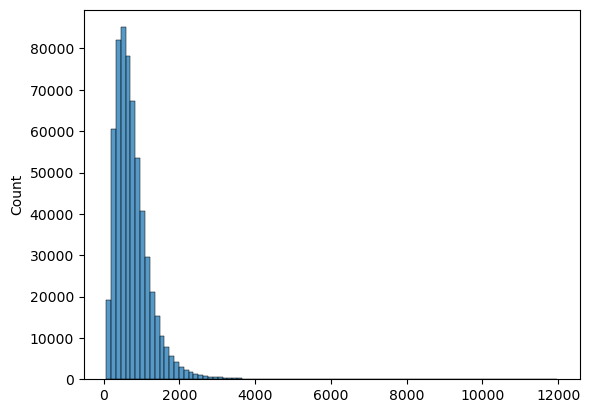

In [28]:
import seaborn as sns
sns.histplot(x=tmp1, binwidth=128)

In [5]:
#model_name = "neulab/codebert-cpp"
#model_name = 'neulab/codebert-cpp'
#model_name = 'microsoft/graphcodebert-base'

model_name = 'codesage/codesage-small'
train_data = pd.read_csv('./all_code.csv')


tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
train_dataset = NewsDataset(train_data, tokenizer, max_len=2048)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)

config.problem_type = "single_label_classification"
config.num_labels = 2
config.classifier_dropout = None
model = AutoModelForSequenceClassification.from_pretrained(
        model_name, config=config, trust_remote_code=True
    )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

/home/server4/anaconda3/envs/jy/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of CodeSageForSequenceClassification were not initialized from the model checkpoint at codesage/codesage-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for epoch in tqdm(range(0,1,1)):
    model.train()
    train_loss = 0
    acc = 0
    tmp_acc = 0
    cnt = 0
    print(f'\nepoch : {epoch+1}')
    for i, batch in tqdm(enumerate(train_loader),leave=False,total=len(train_loader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)
        acc += torch.sum(labels==preds)
        tmp_acc += torch.sum(labels==preds)
        cnt += torch.sum(preds)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        if i%3000==2999:
            print(tmp_acc.item()/ (3000*BATCH_SIZE))
            tmp_acc = 0
        optimizer.step()
        optimizer.zero_grad()
    model.save_pretrained(f"model_infinite_codesage-base/cpp-{epoch}", from_pt=True)
    print(f'train_loss : {train_loss}\nacc = {acc / len(train_data)}\ncount = {cnt}')

  0%|          | 0/1 [00:00<?, ?it/s]


epoch : 1


  0%|          | 0/125000 [00:00<?, ?it/s]

0.5613333333333334
0.774


In [4]:
class testDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.code1 = data['code1'].to_numpy()
        self.code2 = data['code2'].to_numpy()

    def __len__(self):
        return len(self.code1)

    def __getitem__(self, idx):
        code1 = self.code1[idx]
        code2 = self.code2[idx]
        
        encoding = self.tokenizer(
            code1,
            code2,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_tensors="pt",
            padding='max_length'
        )
        

        return {'input_ids': encoding['input_ids'][0],
                'attention_mask': encoding['attention_mask'][0]}


In [5]:
test_data = pd.read_csv('./test.csv')
#model_name = 'microsoft/graphcodebert-base'
model_name = 'codesage/codesage-small'
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
test_dataset = testDataset(test_data, tokenizer, max_len=1024)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
model = AutoModelForSequenceClassification.from_pretrained("model_infinite_codesage/cpp-2", trust_remote_code=True)
model.to(device)
model.eval()
with torch.no_grad():
    test_preds = []
    for i, batch in tqdm(enumerate(test_loader),total=len(test_loader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)
        test_preds.extend(preds.cpu().numpy())
submission = pd.DataFrame({'pair_id': test_data['pair_id'], 'similar': test_preds})
submission.to_csv('./submission.csv', index=False)

  0%|          | 0/9297 [00:00<?, ?it/s]

In [7]:
sum(pd.read_csv('submission.csv')['similar'])

314143